# Battle Ship

In [278]:
import numpy as np
import random
random.seed(42)

import seaborn as sns
import matplotlib.pylab as plt

We define some helper functions first

In [279]:
def plot_board(board):
    """Plot a battleship board."""
    sns.heatmap(board, linewidths=0.5, cmap="tab20c", linecolor="black", cbar=False)
    plt.show()

def plot_probability_heatmap(board):
    """Plot a heatmap of the probability of a ship being in each square."""
    sns.heatmap(board, linewidths=0.5, annot=True, cmap="mako", linecolor="black", cbar=True)
    plt.show()

## 1. Representing the Game

We represent the opponents board as a 2D boolean array, where True means the cell has a ship and False means it doesn't. 

In [280]:
class Board:
    def __init__(self):
        self.board = np.array([[False] * 10] * 10)

    def __str__(self):
        return str(self.board)

    def place_ship(self, ship, is_vert, row, col):
        """
        row, col is top left corner of ships
        Returns True if ship was placed successfully and False otherwise
        Assumes row, col in range [0, 9]
        """
        if is_vert:
            # Make sure ship doesn't go off the board
            if row + ship.length > 10:
                return False
            board_slice = self.board[row:row + ship.length, col]
            if np.any(board_slice):
                return False
            self.board[row:row + ship.length, col] = True
        else:
            # Make sure ship doesn't go off the board
            if col + ship.length > 10:
                return False
            board_slice = self.board[row, col:col + ship.length]
            if np.any(board_slice):
                return False
            self.board[row, col:col + ship.length] = True
        return True

    def generate_random_board(self, ships):
        """Generate the board with ships placed randomly."""

        # Reset board
        self.board[:, :] = False

        # Sequentially place ships
        for ship in ships:
            placed = False
            while not placed:
                is_vert = random.choice([True, False])
                row = random.randint(0, 9)
                col = random.randint(0, 9)
                placed = self.place_ship(ship, is_vert, row, col)

We then have 5 types of ships: Carried, Battleship, Cruiser, Submarine and Destroyer. These have length 5, 4, 3, 3 and 2 respectively. 

In [281]:
class Ship:
    def __init__(self, name, length):
        self.name = name
        self.length = length
        
ships = [Ship("Carrier", 5), Ship("Battleship", 4), Ship("Cruiser", 3), Ship("Submarine", 3), Ship("Destroyer", 2)]

We can now initialise a new board and place a ship

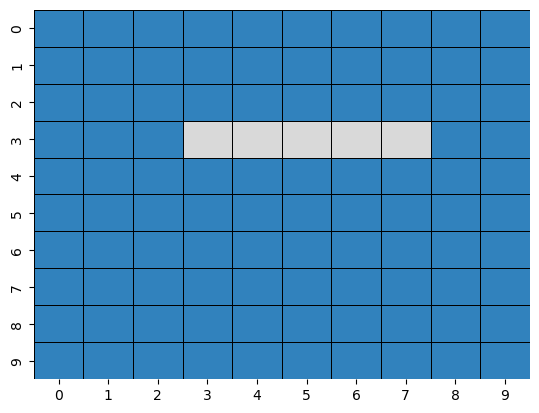

In [282]:
test_board = Board()

# Lets place the Carrier ar row 3, col 3
test_board.place_ship(ships[0], False, 3, 3)
plot_board(test_board.board)

Lets try randomly placing all our ships now

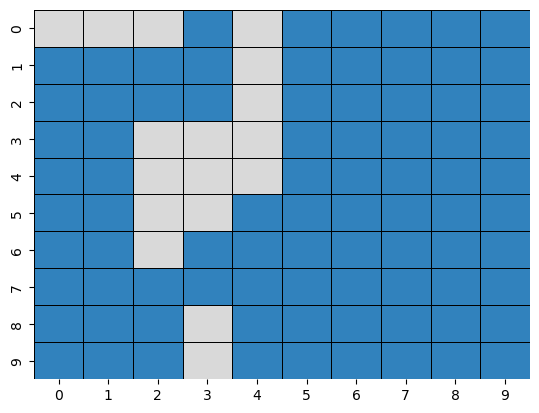

In [283]:
test_board.generate_random_board(ships) # note this function resets the board
plot_board(test_board.board)

## 2. Computing the Probabilities

Now, we need to find the values of to find the $P(X^i = 1) = \theta^i$: the probability that the $i^{\text{th}}$ tile contains a ship. We know that $X^i \sim Ber(\theta^i)$. Hence, our maximum likelyhood estimator gives us:
$$P(X^i = 1) \approx \frac{1}{n} \sum_{j=1}^{n} x^i_j$$ 

where $x_j^i$ is our $i^{\text{th}}$ observation for the $i^{\text{th}}$ tile from our monete carol. $n$ is the number of trails we do. 

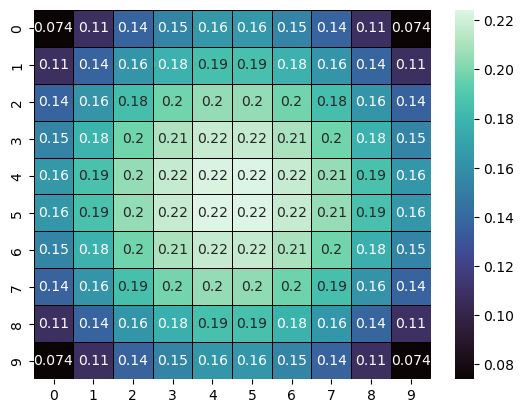

In [285]:
n = 10**6

ship_count_heatmap = np.array([[0] * 10] * 10)
board = Board()
for _ in range(n):
    board.generate_random_board(ships)
    ship_count_heatmap += board.board

probability_heatmap = ship_count_heatmap / n
plot_probability_heatmap(probability_heatmap)


This makes sense. The centre tiles are much more likely to contain ships since there are many ways we can arrage ships in the centre, whereas there fewer ways near the borders. 

Now, what happends to these probabilities when we shoot at a tile? One way to approach this is by conditioning on the result. For example, lets assume we shoot the $0^\text{th}$ tile (row 0, col 0) and register a miss (clearly not optimal play). Then we need to find $ P(X^i = 1 | X^{0} = 0) $. As before $ X^i = 1 | X^{0} = 0 $ follows a bernouli distribution. Hence, we can using our maximum likelyhood approach again. 

$$P(X^i = 1 | X^{0} = 0) \approx \frac{1}{n} \sum_{j=1}^{n} x^i_j$$

where the $j^\text{th}$ observations only are those where $x^{0}_j = 1$, since we know tile (0, 0) has a ship.

We simulate that below.